# Train and Deploy YoloV3 on SageMaker

This example could be used to train and deploy YoloV3 on SageMaker. 

You only look once ([YOLO](https://pjreddie.com/darknet/yolo/)) is a state-of-the-art, real-time object detection system. On a Pascal Titan X it processes images at 30 FPS and has a mAP of 57.9% on COCO test-dev.

**If you are using SageMaker notebook instance, make sure change your kernel to conda_tensorflow2_p36, it is tensorflow 2 not tensorflow.**

In [1]:
import tensorflow as tf
import keras as k

print(k.__version__)
print(tf.__version__)

2.3.0
2.1.0


Using TensorFlow backend.


In [ ]:
#download pretrained weight

!wget https://pjreddie.com/media/files/yolov3.weights -O data/yolov3.weights
!python convert.py --weights ./data/yolov3.weights --output ./checkpoints/yolov3.tf

## Prepare dataset

Download dataset from [PASCAL VOC](http://host.robots.ox.ac.uk/pascal/VOC/)

In [10]:
!wget http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar -O ./data/voc2012_raw.tar
!mkdir -p ./data/voc2012_raw
!tar -xf ./data/voc2012_raw.tar -C ./data/voc2012_raw
!ls ./data/voc2012_raw/VOCdevkit/VOC2012 # Explore the dataset

Annotations  ImageSets	JPEGImages


Transform dataset to tfrecord

In [11]:
%%script bash
python tools/voc2012.py \
  --data_dir './data/voc2012_raw/VOCdevkit/VOC2012' \
  --split train \
  --output_file ./data/voc2012_train.tfrecord

python tools/voc2012.py \
  --data_dir './data/voc2012_raw/VOCdevkit/VOC2012' \
  --split val \
  --output_file ./data/voc2012_val.tfrecord

I0928 12:43:15.335819 140077748365120 voc2012.py:92] Class mapping loaded: {'aeroplane': 0, 'bicycle': 1, 'bird': 2, 'boat': 3, 'bottle': 4, 'bus': 5, 'car': 6, 'cat': 7, 'chair': 8, 'cow': 9, 'diningtable': 10, 'dog': 11, 'horse': 12, 'motorbike': 13, 'person': 14, 'pottedplant': 15, 'sheep': 16, 'sofa': 17, 'train': 18, 'tvmonitor': 19}
I0928 12:43:15.337525 140077748365120 voc2012.py:97] Image list loaded: 5717
100%|██████████| 5717/5717 [00:04<00:00, 1206.71it/s]
I0928 12:43:20.077203 140077748365120 voc2012.py:106] Done
I0928 12:43:22.330870 140440953435968 voc2012.py:92] Class mapping loaded: {'aeroplane': 0, 'bicycle': 1, 'bird': 2, 'boat': 3, 'bottle': 4, 'bus': 5, 'car': 6, 'cat': 7, 'chair': 8, 'cow': 9, 'diningtable': 10, 'dog': 11, 'horse': 12, 'motorbike': 13, 'person': 14, 'pottedplant': 15, 'sheep': 16, 'sofa': 17, 'train': 18, 'tvmonitor': 19}
I0928 12:43:22.331707 140440953435968 voc2012.py:97] Image list loaded: 5823
100%|██████████| 5823/5823 [00:04<00:00, 1180.38it/

Copy dataset to S3 bucket

In [ ]:
import sagemaker
from sagemaker import get_execution_role

role = get_execution_role()

sess = sagemaker.Session()

bucket = sess.default_bucket() # custom bucket name.
prefix = 'DEMO-ObjectDetection-Yolo-tf2'

train_channel = prefix + '/train'
val_channel = prefix + '/val'
classes_channel = prefix + '/classes'
ckpt_channel = prefix + '/ckpt'

#upload 
sess.upload_data(path='./data/voc2012_train.tfrecord', bucket=bucket, key_prefix=train_channel)
sess.upload_data(path='./data/voc2012_val.tfrecord', bucket=bucket, key_prefix=val_channel)
sess.upload_data(path='./data/voc2012.names', bucket=bucket, key_prefix=classes_channel)
sess.upload_data(path='./checkpoints', bucket=bucket, key_prefix=ckpt_channel)


s3_train_data = 's3://{}/{}'.format(bucket, train_channel)
s3_val_data = 's3://{}/{}'.format(bucket, val_channel)
s3_classes_data = 's3://{}/{}'.format(bucket, classes_channel)
s3_ckpt_data = 's3://{}/{}'.format(bucket, ckpt_channel)
print(s3_ckpt_data)

## Training

Prepare training script, we will create a folder named **source_dir** to contain all scripts we would use in training

In [17]:
!mkdir source_dir
!cp yolov3_tf2 source_dir/ -r

mkdir: cannot create directory ‘source_dir’: File exists


In [18]:
%%writefile source_dir/requirements.txt
opencv-python==4.1.1.26
lxml
tqdm

-e .

Writing source_dir/requirements.txt


Below is the script we use to train, let's write it to **'source_code/train.py'**.

Please notice, SageMaker will download dataset from S3 when you call estimator.fit(), and store it to relative local path, we would use os environment to get those path, such as **os.environ['SM_CHANNEL_Train']** is **'/opt/ml/input/data/train'**.

We will save the best ckpt (only one) during the training, and it would be stored in **/opt/ml/model**, then SageMaker will upload it to S3 and release the training instance you used.

In [184]:
%%writefile source_dir/sagemaker-train.py
from absl import app, flags, logging
from absl.flags import FLAGS

import tensorflow as tf
import numpy as np
import cv2
import os
from tensorflow.keras.callbacks import (
    ReduceLROnPlateau,
    EarlyStopping,
    ModelCheckpoint,
    TensorBoard
)
from yolov3_tf2.models import (
    YoloV3, YoloV3Tiny, YoloLoss,
    yolo_anchors, yolo_anchor_masks,
    yolo_tiny_anchors, yolo_tiny_anchor_masks
)
from yolov3_tf2.utils import freeze_all
import yolov3_tf2.dataset as dataset

flags.DEFINE_string('dataset', '', 'path to dataset')
flags.DEFINE_string('val_dataset', '', 'path to validation dataset')
flags.DEFINE_boolean('tiny', False, 'yolov3 or yolov3-tiny')
flags.DEFINE_string('weights', '/opt/ml/checkpoints/yolov3.tf',
                    'path to weights file')
flags.DEFINE_string('classes', os.environ['SM_CHANNEL_CLASSES'], 'path to classes file')
flags.DEFINE_enum('mode', 'fit', ['fit', 'eager_fit', 'eager_tf'],
                  'fit: model.fit, '
                  'eager_fit: model.fit(run_eagerly=True), '
                  'eager_tf: custom GradientTape')
flags.DEFINE_enum('transfer', 'none',
                  ['none', 'darknet', 'no_output', 'frozen', 'fine_tune'],
                  'none: Training from scratch, '
                  'darknet: Transfer darknet, '
                  'no_output: Transfer all but output, '
                  'frozen: Transfer and freeze all, '
                  'fine_tune: Transfer all and freeze darknet only')
flags.DEFINE_integer('size', 416, 'image size')
flags.DEFINE_integer('epochs', 2, 'number of epochs')
flags.DEFINE_integer('batch_size', 8, 'batch size')
flags.DEFINE_float('learning_rate', 1e-3, 'learning rate')
flags.DEFINE_integer('num_classes', 80, 'number of classes in the model')
flags.DEFINE_integer('weights_num_classes', None, 'specify num class for `weights` file if different, '
                     'useful in transfer learning with different number of classes')
flags.DEFINE_string('model_dir', os.environ['SM_MODEL_DIR'], 'path to save model file, it would be s3 path by default')


def main(_argv):
    
    train_dataset = os.path.join(os.environ['SM_CHANNEL_TRAIN'],FLAGS.dataset)
    val_dataset = os.path.join(os.environ['SM_CHANNEL_VAL'], FLAGS.val_dataset)
    classess_file = os.path.join(os.environ['SM_CHANNEL_CLASSES'],FLAGS.classes)
    print('train dataset is ', train_dataset)
    print('val dateset is ', val_dataset)
    print('classess is ', classess_file)
    
    physical_devices = tf.config.experimental.list_physical_devices('GPU')
    for physical_device in physical_devices:
        tf.config.experimental.set_memory_growth(physical_device, True)

    if FLAGS.tiny:
        model = YoloV3Tiny(FLAGS.size, training=True,
                           classes=FLAGS.num_classes)
        anchors = yolo_tiny_anchors
        anchor_masks = yolo_tiny_anchor_masks
    else:
        model = YoloV3(FLAGS.size, training=True, classes=FLAGS.num_classes)
        anchors = yolo_anchors
        anchor_masks = yolo_anchor_masks

    if FLAGS.dataset:
        train_dataset = dataset.load_tfrecord_dataset(
            train_dataset, classess_file, FLAGS.size)
    else:
        train_dataset = dataset.load_fake_dataset()
    
    train_dataset = train_dataset.shuffle(buffer_size=512)
    train_dataset = train_dataset.batch(FLAGS.batch_size)
    train_dataset = train_dataset.map(lambda x, y: (
        dataset.transform_images(x, FLAGS.size),
        dataset.transform_targets(y, anchors, anchor_masks, FLAGS.size)))
    train_dataset = train_dataset.prefetch(
        buffer_size=tf.data.experimental.AUTOTUNE)

    if FLAGS.val_dataset:
        val_dataset = dataset.load_tfrecord_dataset(
            val_dataset, classess_file, FLAGS.size)
    else:
        val_dataset = dataset.load_fake_dataset()
        
    val_dataset = val_dataset.batch(FLAGS.batch_size)
    val_dataset = val_dataset.map(lambda x, y: (
        dataset.transform_images(x, FLAGS.size),
        dataset.transform_targets(y, anchors, anchor_masks, FLAGS.size)))

    # Configure the model for transfer learning
    if FLAGS.transfer == 'none':
        pass  # Nothing to do
    elif FLAGS.transfer in ['darknet', 'no_output']:
        # Darknet transfer is a special case that works
        # with incompatible number of classes

        # reset top layers
        if FLAGS.tiny:
            model_pretrained = YoloV3Tiny(
                FLAGS.size, training=True, classes=FLAGS.weights_num_classes or FLAGS.num_classes)
        else:
            model_pretrained = YoloV3(
                FLAGS.size, training=True, classes=FLAGS.weights_num_classes or FLAGS.num_classes)
        model_pretrained.load_weights(FLAGS.weights)

        if FLAGS.transfer == 'darknet':
            model.get_layer('yolo_darknet').set_weights(
                model_pretrained.get_layer('yolo_darknet').get_weights())
            freeze_all(model.get_layer('yolo_darknet'))

        elif FLAGS.transfer == 'no_output':
            for l in model.layers:
                if not l.name.startswith('yolo_output'):
                    l.set_weights(model_pretrained.get_layer(
                        l.name).get_weights())
                    freeze_all(l)

    else:
        # All other transfer require matching classes
        model.load_weights(FLAGS.weights)
        if FLAGS.transfer == 'fine_tune':
            # freeze darknet and fine tune other layers
            darknet = model.get_layer('yolo_darknet')
            freeze_all(darknet)
        elif FLAGS.transfer == 'frozen':
            # freeze everything
            freeze_all(model)

    optimizer = tf.keras.optimizers.Adam(lr=FLAGS.learning_rate)
    loss = [YoloLoss(anchors[mask], classes=FLAGS.num_classes)
            for mask in anchor_masks]

    if FLAGS.mode == 'eager_tf':
        # Eager mode is great for debugging
        # Non eager graph mode is recommended for real training
        avg_loss = tf.keras.metrics.Mean('loss', dtype=tf.float32)
        avg_val_loss = tf.keras.metrics.Mean('val_loss', dtype=tf.float32)

        for epoch in range(1, FLAGS.epochs + 1):
            for batch, (images, labels) in enumerate(train_dataset):
                with tf.GradientTape() as tape:
                    outputs = model(images, training=True)
                    regularization_loss = tf.reduce_sum(model.losses)
                    pred_loss = []
                    for output, label, loss_fn in zip(outputs, labels, loss):
                        pred_loss.append(loss_fn(label, output))
                    total_loss = tf.reduce_sum(pred_loss) + regularization_loss

                grads = tape.gradient(total_loss, model.trainable_variables)
                optimizer.apply_gradients(
                    zip(grads, model.trainable_variables))

                logging.info("{}_train_{}, {}, {}".format(
                    epoch, batch, total_loss.numpy(),
                    list(map(lambda x: np.sum(x.numpy()), pred_loss))))
                avg_loss.update_state(total_loss)

            for batch, (images, labels) in enumerate(val_dataset):
                outputs = model(images)
                regularization_loss = tf.reduce_sum(model.losses)
                pred_loss = []
                for output, label, loss_fn in zip(outputs, labels, loss):
                    pred_loss.append(loss_fn(label, output))
                total_loss = tf.reduce_sum(pred_loss) + regularization_loss

                logging.info("{}_val_{}, {}, {}".format(
                    epoch, batch, total_loss.numpy(),
                    list(map(lambda x: np.sum(x.numpy()), pred_loss))))
                avg_val_loss.update_state(total_loss)

            logging.info("{}, train: {}, val: {}".format(
                epoch,
                avg_loss.result().numpy(),
                avg_val_loss.result().numpy()))

            avg_loss.reset_states()
            avg_val_loss.reset_states()
            model.save_weights(
                'checkpoints/yolov3_train_{}.tf'.format(epoch))
    else:
        model.compile(optimizer=optimizer, loss=loss,
                      run_eagerly=(FLAGS.mode == 'eager_fit'))

        callbacks = [
            ReduceLROnPlateau(verbose=1),
            EarlyStopping(patience=3, verbose=1),
            ModelCheckpoint('/opt/ml/model/yolov3_train.tf', #yolov3_train_{epoch}.tf'
                            verbose=1, save_weights_only=True, save_best_only=True),
            TensorBoard(log_dir='logs')
        ]

        history = model.fit(train_dataset,
                            epochs=FLAGS.epochs,
                            callbacks=callbacks,
                            validation_data=val_dataset)


if __name__ == '__main__':
    try:
        app.run(main)
    except SystemExit:
        pass

Writing source_dir/sagemaker-train.py


In [35]:
import sagemaker
from sagemaker.tensorflow import TensorFlow

train_instance_type = 'ml.p3.2xlarge'

train_use_spot_instances = True
train_max_run=432000
train_max_wait = 432000 if train_use_spot_instances else None

hyperparameters = {
                    'dataset':'voc2012_train.tfrecord',
                    'val_dataset':'voc2012_val.tfrecord',
                    'classes':'voc2012.names',
                    'mode':'fit',
                    'transfer':'darknet',
                    'num_classes':20,
                    'weights_num_classes':80,
                    'batch_size':16,
                    'epochs':40,
                    'learning_rate':1e-3
                  }

estimator = TensorFlow(entry_point='sagemaker-train.py',
                       source_dir='source_dir',
                       train_instance_type=train_instance_type,
                       train_instance_count=1,
                       train_volume_size=30,
                       checkpoint_s3_uri=s3_ckpt_data, #ckpt with pretrained weights
                       hyperparameters=hyperparameters,
                       role=sagemaker.get_execution_role(),
                       base_job_name='yolo-tf2',
                       py_version='py3',
                       train_use_spot_instances=train_use_spot_instances,
                       train_max_wait=train_max_wait,
                       train_max_run=train_max_run,
                       framework_version='2.1.0'
                       )

In [ ]:
inputs = {'train': s3_train_data,'val':s3_val_data,'classes':s3_classes_data}

estimator.fit(inputs)

## Inference in local

Create a folder to store model artifact.

In [43]:
!mkdir model
!mkdir model/ckpt

Download model artifact from S3

In [37]:
model_data = estimator.model_data
_model_path = model_data.split('//')
index = _model_path[1].find('/')
key_prefix = _model_path[1][index+1:]

sess.download_data(path='./model/ckpt/',bucket=bucket,key_prefix=key_prefix)

!cd model && tar -xzvf model.tar.gz 

yolov3_train_2.tf.data-00001-of-00002
yolov3_train_1.tf.data-00000-of-00002
yolov3_train_3.tf.data-00000-of-00002
yolov3_train_4.tf.data-00001-of-00002
yolov3_train_6.tf.index
yolov3_train_2.tf.index
yolov3_train_2.tf.data-00000-of-00002
checkpoint
yolov3_train_6.tf.data-00001-of-00002
yolov3_train_4.tf.data-00000-of-00002
yolov3_train_1.tf.index
yolov3_train_4.tf.index
yolov3_train_1.tf.data-00001-of-00002
yolov3_train_6.tf.data-00000-of-00002
yolov3_train_3.tf.data-00001-of-00002
yolov3_train_3.tf.index


In [38]:
# delete model.tar.gz to save disk space
!rm ./model/model.tar.gz

Run a local test

In [126]:
!python detect.py --classes ./data/voc2012.names --num_classes 20 --weights ./model/ckpt/yolov3_train.tf --image ./data/street.jpg

2020-09-29 03:54:23.053349: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX512F
2020-09-29 03:54:23.080933: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2499990000 Hz
2020-09-29 03:54:23.081187: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55db396bc120 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2020-09-29 03:54:23.081208: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2020-09-29 03:54:23.081309: I tensorflow/core/common_runtime/process_util.cc:147] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
I0929 03:54:27.390874 139764038768448 detect.py:35] weights loaded
I0929 03:54:27.391160 139764038768448 detect.py:38] classes loaded
I0929 03:54:28.068380 139764038768448 detect.py:55] t

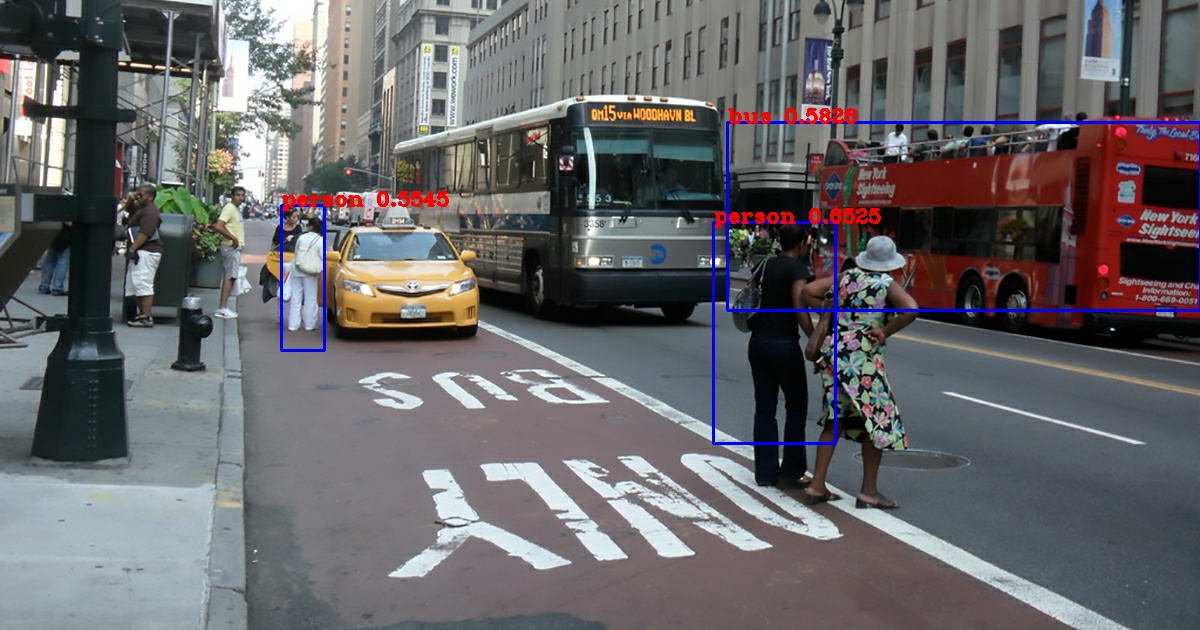

In [127]:
# Have a visual to see what we get
from IPython.display import Image
Image(filename='./output.jpg')

#### Convert model from ckpt to tf serving model

In [47]:
!python tools/export_tfserving.py --weights model/ckpt/yolov3_train.tf --classes data/voc2012.names --num_classes 20 --output model/yolov3/1/
# verify tfserving graph
!saved_model_cli show --dir model/yolov3/1/ --tag_set serve --signature_def serving_default

The given SavedModel SignatureDef contains the following input(s):
  inputs['input'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, -1, -1, 3)
      name: serving_default_input:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['yolo_nms'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 100, 4)
      name: StatefulPartitionedCall:0
  outputs['yolo_nms_1'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 100)
      name: StatefulPartitionedCall:1
  outputs['yolo_nms_2'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 100)
      name: StatefulPartitionedCall:2
  outputs['yolo_nms_3'] tensor_info:
      dtype: DT_INT32
      shape: (-1)
      name: StatefulPartitionedCall:3
Method name is: tensorflow/serving/predict


**Run model in TensorFlow Serving by using TFS container, you should run below command in terminal.**

In [ ]:
%%sh
docker pull tensorflow/serving
docker run -p 8501:8501 \
  --mount type=bind,source=/home/ec2-user/SageMaker/yolov3-tf2/model/yolov3,target=/models/yolo \
-e MODEL_NAME=yolo -t tensorflow/serving &

The inputs are preprocessed images (see yolov3-tf2/dataset.transform_iamges)

**outputs are**

yolo_nms: bounding boxes

yolo_nms_1: scores

yolo_nms_2: classes

yolo_nms_3: numbers of valid detections


##### Test model in TFS container

In [ ]:
import yolov3_tf2.dataset as dataset
import requests,json
from PIL import Image
import numpy as np

file_name = './data/street.jpg'

img_raw = tf.image.decode_image(open(file_name, 'rb').read(), channels=3)
img = tf.expand_dims(img_raw, 0)
img = dataset.transform_images(img,416)

url = 'http://localhost:8501/v1/models/yolo:predict'
data = json.dumps({'instances':img.numpy().tolist()})

r =requests.post(url,data)
r = json.loads(r.text)
print(r)
boxes, scores, classes, nums = r['predictions'][0]["yolo_nms"], r['predictions'][0][
        "yolo_nms_1"], r['predictions'][0]["yolo_nms_2"], r['predictions'][0]["yolo_nms_3"]

person 0.652511656 [0.59453082 0.35280561 0.69584012 0.70386696]
bus 0.582620502 [0.60583687 0.1943617  1.         0.49235427]
person 0.554472208 [0.23435248 0.32632047 0.27073169 0.55708206]


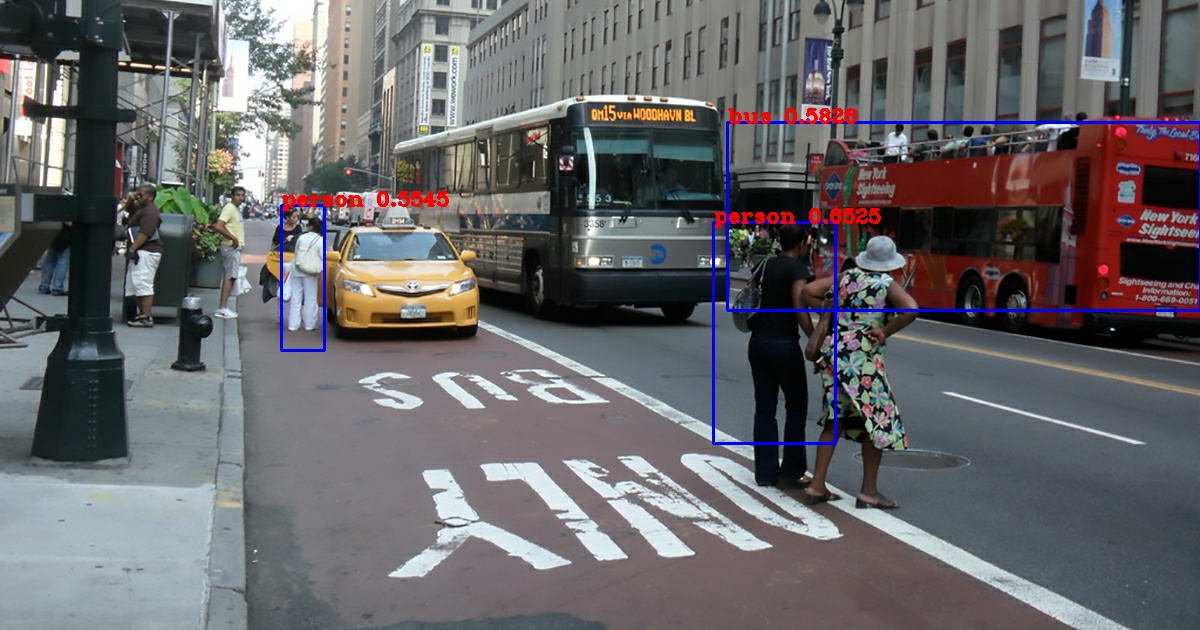

In [161]:
import cv2
import numpy as np

def draw_outputs(img, outputs, class_names):
    boxes, objectness, classes, nums = outputs
    boxes, objectness, classes, nums = boxes, objectness, classes, nums
    wh = np.flip(img.shape[0:2])
    for i in range(nums):
        x1y1 = tuple((np.array(boxes[i][0:2]) * wh).astype(np.int32))
        x2y2 = tuple((np.array(boxes[i][2:4]) * wh).astype(np.int32))
        img = cv2.rectangle(img, x1y1, x2y2, (255, 0, 0), 2)
        img = cv2.putText(img, '{} {:.4f}'.format(
            class_names[int(classes[i])], objectness[i]),
            x1y1, cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (0, 0, 255), 2)
    return img


class_names = [c.strip() for c in open('./data/voc2012.names').readlines()]

for i in range(nums):
    print(class_names[int(classes[i])], np.array(scores[i]), np.array(boxes[i]))

img = cv2.cvtColor(img_raw.numpy(), cv2.COLOR_RGB2BGR)
img = draw_outputs(img, (boxes, scores, classes, nums), class_names)

from IPython.display import Image, display
display(Image(data=bytes(cv2.imencode('.jpg', img)[1]), width=800))



##### If you only want to deploy model in local environment, then you can skip below cell.

---

## Deploy model in SageMaker

Now we will deploy the model to SageMake and send request to inference.

1. Package saved model to model.tar.gz

2. Upload model to S3

3. Create Endpoint

In [167]:
!cd model/yolov3/1 && tar -czvf ../model.tar.gz ./

./
./assets/
./saved_model.pb
./variables/
./variables/variables.data-00000-of-00001
./variables/variables.index


In [168]:
savedmodel_channel = prefix + '/savedmodel'
sess.upload_data(path='./model/model.tar.gz', bucket=bucket, key_prefix=savedmodel_channel)
savedmodel_data = 's3://{}/{}'.format(bucket, savedmodel_channel)

In [170]:
from sagemaker.tensorflow.serving import Model

endpoint_name = 'tfs-yolov3'

tfs_model = Model(model_data=savedmodel_data + '/model.tar.gz', role=role, framework_version='2.1.0')

predictor = tfs_model.deploy(initial_instance_count=1, 
                             instance_type='ml.g4dn.xlarge', 
                             endpoint_name=endpoint_name)

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.
'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


-------------!

time cost 0.37136411666870117 s
person 0.652512074 [0.59453082 0.35280561 0.69584012 0.70386696]
bus 0.582619607 [0.605837   0.19436164 1.         0.49235421]
person 0.554472387 [0.23435248 0.3263205  0.27073166 0.55708206]


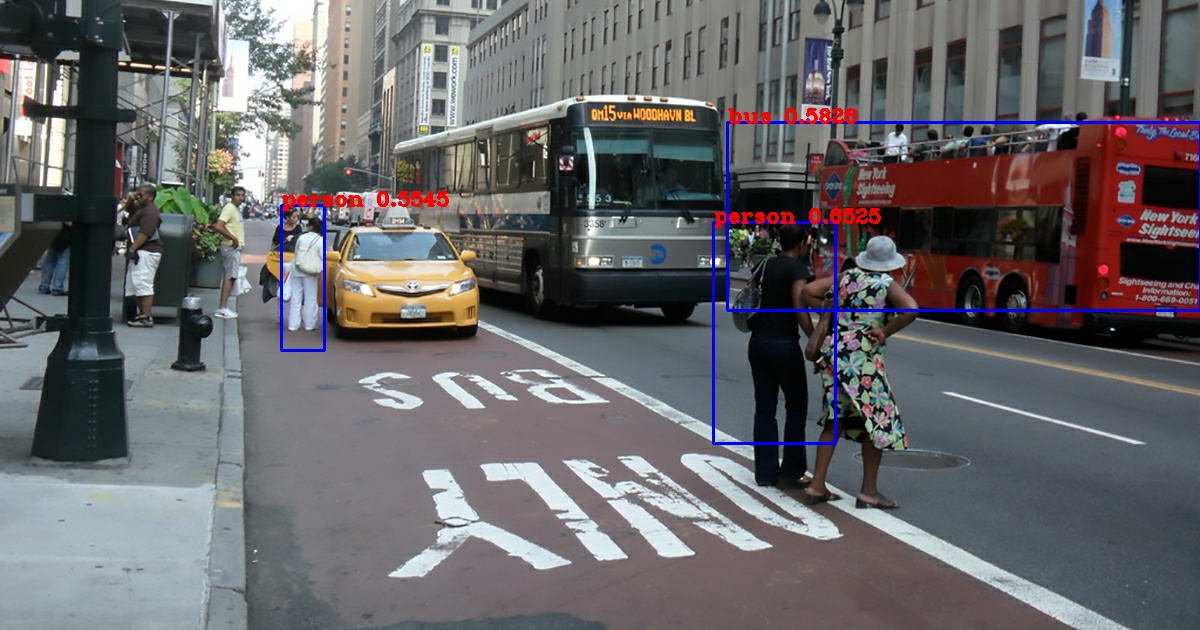

In [181]:
import yolov3_tf2.dataset as dataset
import requests,json
from PIL import Image
import numpy as np
import boto3
import time

session = boto3.session.Session(region_name='us-west-2', profile_name='default')
client = session.client('sagemaker-runtime')

file_name = './data/street.jpg'


img_raw = tf.image.decode_image(open(file_name, 'rb').read(), channels=3)
img = tf.expand_dims(img_raw, 0)
img = dataset.transform_images(img,416)


data = json.dumps({'instances':img.numpy().tolist()})

start_time = time.time()
rr=client.invoke_endpoint(EndpointName=endpoint_name, Body=data, ContentType='application/json')
end_time = time.time()
print('time cost %s s' %(end_time - start_time))

rr = json.loads(rr['Body'].read().decode())

boxes, scores, classes, nums = rr['predictions'][0]["yolo_nms"], rr['predictions'][0][
        "yolo_nms_1"], rr['predictions'][0]["yolo_nms_2"], rr['predictions'][0]["yolo_nms_3"]

class_names = [c.strip() for c in open('./data/voc2012.names').readlines()]

for i in range(nums):
    print(class_names[int(classes[i])], np.array(scores[i]), np.array(boxes[i]))

img = cv2.cvtColor(img_raw.numpy(), cv2.COLOR_RGB2BGR)
img = draw_outputs(img, (boxes, scores, classes, nums), class_names)

from IPython.display import Image, display
display(Image(data=bytes(cv2.imencode('.jpg', img)[1]), width=800))

## Delete Endpoint

In [183]:
sess.delete_endpoint(predictor.endpoint)

## Reference

https://github.com/zzh8829/yolov3-tf2

https://sagemaker.readthedocs.io/en/v1.71.0/frameworks/tensorflow/using_tf.html

